In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from LQN_igraph_copy import *
import itertools
from copy import deepcopy
import sympy as sp
from itertools import groupby

In [3]:
import igraph as ig
import hashlib

In [4]:
def epm_process(num_system, num_ancilla):
    graph_generator = EPM_bipartite_graph_generator_igraph(num_system, num_ancilla)
    canonical_groups = process_and_group_by_canonical_form(graph_generator)
    filtered_groups = filter_groups_by_scc_igraph(canonical_groups)
    unique_bigraph = extract_unique_bigraphs_from_groups_igraph(filtered_groups)
    return unique_bigraph

In [5]:
num_system = 3
num_ancilla = 2

In [6]:
canonical_groups = epm_process(num_system, num_ancilla)

In [7]:
total_elements = sum(len(v) for v in canonical_groups.values())  # 모든 리스트 요소 개수 합산
print(total_elements)  # 출력: 9

655


In [8]:
list(canonical_groups.keys())

['5412046da0c318a980c7edbc89a98ed62e7a3dc5f8b6c5a9edfd6f9656609844',
 '9a98a0100458abb4267e3e9c0d724799f7920693c9318f425aebea6789339b59',
 '22698ea5a87cccad8ec04918ae76b00be7c4e1ab28820bfd29a9bbc5d13ea8af',
 '1f911f527de5d2bf3ab5f4e2a3ca1c9653df2adf8c53112a3b9437276a6e4916',
 '7d529fc2fb04c765eecdb1de9779eac0d8111f753df47a2788ee5113679c2782',
 '03c7aa5b9de7b327da92ef0397235030676d9e0dbb6c1f951966882a70bbf963',
 '2d0ad4361fc9520493fbee367c6150c6a5f92c664fad77050ddec114cbf4430f',
 'd6d64899958ccdaab33e97e94b9db5ef7a331f098da328fab2b546fca1322252',
 '462053cef68219cc3b9878afd6c20575c9fb993716d071b0573519a7fc6c8131',
 '73777a7d7a4f0c8eba6e8b7e9ab48313064ff1b15fc09b5d5d4b9545ac6ea85b',
 '2cac5f123c094b1c33c44fa3177e329394b176d8dadadf2ecf0950b95545ddb3',
 'b9d4638a281feef598e917def4d0acbe0b68c79ad28944abeb099dbd16a5012c',
 '35dc3bbfda37a02fd29aef4d1d574729f37a5a7dec87c9630853c0b239a26108',
 '36f147d27455e5e19f70cc7f940dce0dafab2cc9c630477d3b5183e27aa4cf8f',
 '1bb0c2f35823d50c47ede23f690c9491

In [9]:
canonical_groups[list(canonical_groups.keys())[0]]

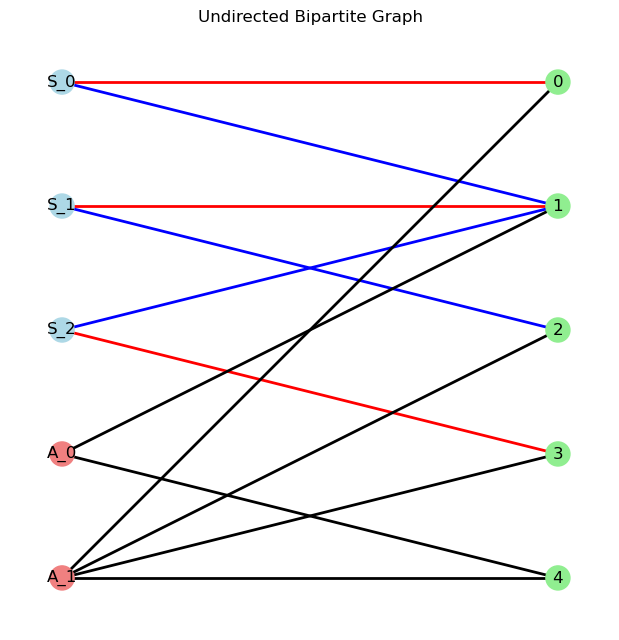

In [10]:
Draw_EPM_bipartite_graph(igraph_to_networkx(canonical_groups[list(canonical_groups.keys())[0]][2]))

In [11]:
import igraph as ig
from collections import Counter
from math import gcd
from functools import reduce

def is_perfect_matching(G, matching):
    """
    Check if a matching is a perfect matching for the graph.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
    matching : list
        List of edges in the matching
        
    Returns:
    --------
    bool
        True if the matching is perfect, False otherwise
    """
    # Perfect matching should cover half of the nodes in bipartite graph
    return len(matching) == len(G.vs) // 2

def get_bipartite_sets(G):
    """
    Extract the bipartite sets from igraph object.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
        
    Returns:
    --------
    tuple
        (U, V) where U and V are lists of node indices in each partition
    """
    # Check if graph has bipartite attribute
    if 'bipartite' in G.vs.attributes():
        U = [v.index for v in G.vs if v['bipartite'] == 0]
        V = [v.index for v in G.vs if v['bipartite'] == 1]
    elif 'category' in G.vs.attributes():
        # Extract based on category attribute (for EPM graphs)
        U = [v.index for v in G.vs if v['category'] in ['system_nodes', 'ancilla_nodes']]
        V = [v.index for v in G.vs if v['category'] == 'sculpting_nodes']
    else:
        # If not explicitly marked, try to infer bipartite structure
        # Assuming bipartite graph with equal sets
        n = len(G.vs) // 2
        U = list(range(0, n))
        V = list(range(n, 2*n))
    
    return U, V

def get_edge_weight(G, u, v):
    """
    Get weight of edge between u and v.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
    u : int
        Source node index
    v : int
        Target node index
        
    Returns:
    --------
    float or None
        Weight of the edge if it exists, None otherwise
    """
    eid = G.get_eid(u, v, error=False)
    if eid == -1:
        return None
    
    if 'weight' in G.es.attributes():
        # Just return the weight as is
        return G.es[eid]['weight']
    return '+'  # Default weight if not specified

def dfs_all_matchings(G, U, V, current_matching, all_matchings, all_weights, matched, u_index=0):
    """
    Use DFS to find all perfect matchings in a bipartite graph.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
    U : list
        List of node indices in the first partition
    V : list
        List of node indices in the second partition
    current_matching : list
        Current matching being built
    all_matchings : list
        List to store all perfect matchings found
    all_weights : list
        List to store weight strings for each perfect matching
    matched : dict
        Dictionary keeping track of which nodes are matched
    u_index : int, optional
        Current index in U to start from (default: 0)
    """
    if is_perfect_matching(G, current_matching):
        all_matchings.append(current_matching[:])
        
        # Map weights to corresponding quantum states:
        # weight 1.0 -> state 0
        # weight 2.0 -> state 1
        # weight 3.0 -> state 2 (if needed)
        weights_list = []
        for u, v, w in current_matching:
            if w == 1.0:
                weights_list.append('0')
            elif w == 2.0:
                weights_list.append('1')
            elif w == 3.0:
                # Include state 2 only if we want to represent ancilla
                # Currently skipping as per previous requirement
                pass
        
        matching_key = ''.join(weights_list)
        all_weights.append(matching_key)
        return

    # Start from current index to avoid redundant checks
    for i in range(u_index, len(U)):
        u = U[i]
        if matched[u]:
            continue

        for v in V:
            if not matched[v]:
                # Check if edge exists
                weight = get_edge_weight(G, u, v)
                if weight is not None:
                    current_matching.append((u, v, weight))
                    matched[u] = True
                    matched[v] = True

                    # Recursive call with next index
                    dfs_all_matchings(G, U, V, current_matching, all_matchings, all_weights, matched, i + 1)

                    # Backtrack
                    matched[u] = False
                    matched[v] = False
                    current_matching.pop()

def find_all_perfect_matchings(G):
    """
    Find all perfect matchings in a bipartite graph.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
        
    Returns:
    --------
    tuple
        (all_matchings, all_weights) where:
        - all_matchings is a list of perfect matchings
        - all_weights is a list of weight strings for each matching
    """
    U, V = get_bipartite_sets(G)
    all_matchings = []
    all_weights = []
    matched = {node: False for node in range(len(G.vs))}

    dfs_all_matchings(G, U, V, [], all_matchings, all_weights, matched)
    
    return all_matchings, all_weights

def find_unused_edges(G, perfect_matchings):
    """
    Find edges that are not used in any perfect matching.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
    perfect_matchings : list
        List of perfect matchings
        
    Returns:
    --------
    list
        List of edges (as tuples) that are not used in any perfect matching
    """
    # Create a set of all edges used in any perfect matching
    used_edges = set()
    for matching in perfect_matchings:
        for u, v, _ in matching:
            used_edges.add((u, v))
            used_edges.add((v, u))  # Add both directions since igraph may use either

    # Find unused edges
    unused_edges = []
    for edge in G.es:
        edge_tuple = (edge.source, edge.target)
        if edge_tuple not in used_edges:
            unused_edges.append(edge_tuple)
    
    return unused_edges

def find_pm_of_bigraph(graph_list):
    """
    Find perfect matchings for each graph in the list.
    
    Parameters:
    -----------
    graph_list : list
        List of igraph.Graph objects
        
    Returns:
    --------
    list
        List of [Counter(weight_strings), perfect_matchings, graph, index] for valid graphs
    """
    save_fw_results = []

    for i, G in enumerate(graph_list):
        perfect_matching_result, weight_strings = find_all_perfect_matchings(G)
        
        if not find_unused_edges(G, perfect_matching_result) and len(perfect_matching_result) >= 2:
            save_fw_results.append([
                Counter(weight_strings),
                perfect_matching_result,
                G,
                i  # Index in the original graph list
            ])
    
    # Normalize coefficients using GCD
    for i in save_fw_results:
        values = list(i[0].values())
        if values:
            gcd_of_values = reduce(gcd, values)
            for key in i[0]:
                i[0][key] //= gcd_of_values
    
    return save_fw_results

def remove_same_state(save_fw_results):
    """
    Remove duplicate states based on weight counters.
    
    Parameters:
    -----------
    save_fw_results : list
        List of [Counter(weight_strings), perfect_matchings, graph, index]
        
    Returns:
    --------
    list
        List of unique entries based on state counter
    """
    seen = set()
    unique_counters = []

    for counter in save_fw_results:
        counter_tuple = tuple(sorted(counter[0].items()))
        
        if counter_tuple not in seen:
            seen.add(counter_tuple)
            unique_counters.append(counter)
    
    return unique_counters

def apply_bit_flip(state, positions):
    """
    Apply X-operator (bit flip) to specified positions in a quantum state.
    
    Parameters:
    -----------
    state : str
        Quantum state as a string (e.g. '0101')
    positions : list
        List of positions to flip (0-indexed from left)
        
    Returns:
    --------
    str
        New quantum state after applying bit flips
    """
    state_list = list(state)
    for pos in positions:
        if pos < len(state_list):
            # Flip 0 -> 1 or 1 -> 0
            state_list[pos] = '1' if state_list[pos] == '0' else '0'
    
    return ''.join(state_list)

def check_quantum_states_with_bit_flips(result_dict, target_states, bit_flip_positions=None, hash_key=None):
    """
    Check if quantum states exist, considering possible bit flips at specified positions.
    
    Parameters:
    -----------
    result_dict : dict
        Result dictionary returned from process_graph_dict() function
    target_states : list or str
        List of quantum states to search for, or a single state as string
    bit_flip_positions : list or None
        List of positions where bit flips should be tried.
        If None, all possible combinations of bit flips will be tried.
        For example: [0] means try flipping only the leftmost bit
                     [0,1] means try flipping leftmost, second bit, or both
    hash_key : str, optional
        Specific hash key to search within (default: None, search all hashes)
        
    Returns:
    --------
    list
        [(hash_key, {original_state: flipped_state}, {flipped_state: coefficient}, graph_index, bit_flip_applied), ...]
        List of results where states were found after possible bit flips:
        - hash_key: Hash key where the states were found
        - original_to_flipped: Mapping from original states to the states after bit flips
        - state_coefficients: Dictionary of flipped states and their coefficients
        - graph_index: Index in the original graph list
        - bit_flip_applied: List of positions where bits were flipped
    """
    results = []
    
    # Convert single state to list for consistent processing
    if isinstance(target_states, str):
        target_states = [target_states]
    
    # Determine hash keys to search
    if hash_key is not None:
        if hash_key not in result_dict:
            return []
        hash_keys = [hash_key]
    else:
        hash_keys = result_dict.keys()
    
    # If no specific positions provided, assume all positions could have bit flips
    if bit_flip_positions is None and len(target_states) > 0 and len(target_states[0]) > 0:
        max_length = max(len(state) for state in target_states)
        bit_flip_positions = list(range(max_length))
    
    # Generate all possible combinations of bit flip positions
    from itertools import combinations, chain
    all_combinations = list(chain.from_iterable(
        combinations(bit_flip_positions, r) for r in range(len(bit_flip_positions) + 1)
    ))
    
    # Search through each hash key and try each bit flip combination
    for key in hash_keys:
        for state_data in result_dict[key]:
            counter = state_data[0]  # State coefficient Counter
            graph_index = state_data[3]  # Graph index
            
            for bit_positions in all_combinations:
                # Skip empty combination (no bit flips) if there are other combinations
                if not bit_positions and len(all_combinations) > 1:
                    continue
                
                # Apply bit flips to target states
                flipped_targets = [apply_bit_flip(state, bit_positions) for state in target_states]
                
                # Check if all flipped target states exist in this counter
                all_states_exist = all(state in counter for state in flipped_targets)
                
                if all_states_exist:
                    # Create mapping from original states to flipped states
                    original_to_flipped = {original: flipped for original, flipped in zip(target_states, flipped_targets)}
                    
                    # Create dictionary of flipped states and their coefficients
                    state_coefficients = {state: counter[state] for state in flipped_targets}
                    
                    results.append((
                        key, 
                        original_to_flipped,
                        state_coefficients, 
                        graph_index, 
                        list(bit_positions)
                    ))
    
    return results

def check_quantum_states_exist(result_dict, target_states, hash_key=None):
    """
    Check if all specified quantum states exist in the results.
    
    Parameters:
    -----------
    result_dict : dict
        Result dictionary returned from process_graph_dict() function
    target_states : list or str
        List of quantum states to search for (e.g. ['0101', '1010']) or a single state as string
    hash_key : str, optional
        Specific hash key to search within (default: None, search all hashes)
        
    Returns:
    --------
    list
        [(hash_key, {state1: coefficient1, state2: coefficient2, ...}, graph_index), ...] 
        List of results where all target states exist:
        - hash_key: Hash key where the states were found
        - state_coefficients: Dictionary of states and their coefficients
        - graph_index: Index in the original graph list
    """
    results = []
    
    # Convert single state string to list for consistent processing
    if isinstance(target_states, str):
        target_states = [target_states]
    
    # Determine which hash keys to search
    if hash_key is not None:
        if hash_key not in result_dict:
            return []
        hash_keys = [hash_key]
    else:
        hash_keys = result_dict.keys()
    
    # Search through each hash key
    for key in hash_keys:
        for state_data in result_dict[key]:
            counter = state_data[0]  # State coefficient Counter
            graph_index = state_data[3]  # Graph index
            
            # Check if all target states exist in this counter
            all_states_exist = all(state in counter for state in target_states)
            
            if all_states_exist:
                # Create dictionary of states and their coefficients
                state_coefficients = {state: counter[state] for state in target_states}
                results.append((key, state_coefficients, graph_index))
    
    return results

def process_graph_dict(graph_dict):
    """
    Process dictionary of graphs to find states.
    
    Parameters:
    -----------
    graph_dict : dict
        Dictionary mapping hash keys to lists of igraph.Graph objects
        
    Returns:
    --------
    dict
        Dictionary mapping hash keys to lists of [Counter, matchings, graph, index]
    """
    result_dict = {}
    
    for hash_key, graph_list in graph_dict.items():
        # Find perfect matchings for this graph list
        fw_results = find_pm_of_bigraph(graph_list)
        
        # Remove duplicate states
        unique_results = remove_same_state(fw_results)
        
        # Add to result dictionary
        if unique_results:
            result_dict[hash_key] = unique_results
    
    return result_dict

def get_all_quantum_states(result_dict, hash_key=None):
    """
    Returns all quantum states found in the results.
    
    Parameters:
    -----------
    result_dict : dict
        Result dictionary returned from process_graph_dict() function
    hash_key : str, optional
        Specific hash key to search within (default: None, search all hashes)
        
    Returns:
    --------
    dict
        {hash_key: {state: [(coefficient, graph_index), ...], ...}, ...}
        Dictionary mapping each hash key to its states and occurrences
    """
    states_dict = {}
    
    # Determine which hash keys to search
    if hash_key is not None:
        if hash_key not in result_dict:
            return {}
        hash_keys = [hash_key]
    else:
        hash_keys = result_dict.keys()
    
    # Collect states from each hash key
    for key in hash_keys:
        states_dict[key] = {}
        
        for state_data in result_dict[key]:
            counter = state_data[0]  # State coefficient Counter
            graph_index = state_data[3]  # Graph index
            
            # Store all states
            for state, coefficient in counter.items():
                if state not in states_dict[key]:
                    states_dict[key][state] = []
                states_dict[key][state].append((coefficient, graph_index))
    
    return states_dict

# Example usage:
# graph_dict = {
#     'hash1': [graph1, graph2, ...],
#     'hash2': [graph3, graph4, ...],
# }
# result = process_graph_dict(graph_dict)
# 
# # Search for multiple quantum states
# # Returns only results where all specified states exist
# states_to_find = ['010', '101']
# state_results = check_quantum_states_exist(result, states_to_find)
# for hash_key, state_coefficients, graph_index in state_results:
#     print(f"All states {states_to_find} found in hash {hash_key} (graph index: {graph_index})")
#     for state, coefficient in state_coefficients.items():
#         print(f"  State '{state}' has coefficient {coefficient}")
#
# # Search with bit flips - find states after applying X operators
# # Searches for states considering all possible bit flips
# states_to_find = ['011', '101']
# bit_flip_results = check_quantum_states_with_bit_flips(result, states_to_find)
# for hash_key, original_to_flipped, state_coefficients, graph_index, bit_positions in bit_flip_results:
#     print(f"States found in hash {hash_key} after applying X operators at positions {bit_positions}")
#     for original, flipped in original_to_flipped.items():
#         print(f"  Original: '{original}' → Flipped: '{flipped}' (coef: {state_coefficients[flipped]})")
#
# # Check specific bit flip positions only
# # Only try flipping the first and second bits
# specific_positions = [0, 1]  
# specific_results = check_quantum_states_with_bit_flips(result, states_to_find, bit_flip_positions=specific_positions)
#
# # Get all quantum states
# all_states = get_all_quantum_states(result)
# for hash_key, states in all_states.items():
#     print(f"\nHash: {hash_key}")
#     for state, occurrences in states.items():
#         print(f"  State: {state}, Found {len(occurrences)} times")
#         for coefficient, graph_index in occurrences:
#             print(f"    - Coefficient: {coefficient}, Graph index: {graph_index}")

In [12]:
# graph_dict contains your dictionary of igraph objects
result_dict = process_graph_dict(canonical_groups)

# Accessing results
for hash_key, states in result_dict.items():
    print(f"Hash: {hash_key}")
    for state in states:
        counter, matchings, graph, index = state
        print(f"  State coefficients: {dict(counter)}")

Hash: 5412046da0c318a980c7edbc89a98ed62e7a3dc5f8b6c5a9edfd6f9656609844
  State coefficients: {'011': 1, '101': 1, '110': 1, '111': 1}
  State coefficients: {'010': 1, '100': 1, '111': 1, '110': 1}
  State coefficients: {'000': 1, '011': 1, '010': 1, '110': 1}
  State coefficients: {'010': 1, '001': 1, '000': 1, '100': 1}
Hash: 9a98a0100458abb4267e3e9c0d724799f7920693c9318f425aebea6789339b59
  State coefficients: {'011': 1, '101': 1, '110': 1, '111': 2}
  State coefficients: {'010': 1, '100': 1, '111': 1, '110': 2}
  State coefficients: {'000': 1, '011': 1, '010': 2, '110': 1}
  State coefficients: {'010': 1, '001': 1, '000': 2, '100': 1}
Hash: 22698ea5a87cccad8ec04918ae76b00be7c4e1ab28820bfd29a9bbc5d13ea8af
  State coefficients: {'011': 1, '101': 1, '110': 1}
  State coefficients: {'010': 1, '101': 1, '111': 1}
  State coefficients: {'010': 1, '011': 1, '101': 1}
  State coefficients: {'010': 1, '100': 1, '111': 1}
  State coefficients: {'011': 1, '100': 1, '110': 1}
  State coefficien

In [13]:
result_dict

{'5412046da0c318a980c7edbc89a98ed62e7a3dc5f8b6c5a9edfd6f9656609844': [[Counter({'011': 1,
            '101': 1,
            '110': 1,
            '111': 1}),
   [[(0, 5, 1.0), (1, 7, 2.0), (2, 8, 2.0), (3, 9, 3.0), (4, 6, 3.0)],
    [(0, 6, 2.0), (1, 5, 1.0), (2, 8, 2.0), (3, 9, 3.0), (4, 7, 3.0)],
    [(0, 6, 2.0), (1, 7, 2.0), (2, 5, 1.0), (3, 9, 3.0), (4, 8, 3.0)],
    [(0, 6, 2.0), (1, 7, 2.0), (2, 8, 2.0), (3, 5, 3.0), (4, 9, 3.0)]],
   0],
  [Counter({'010': 1, '100': 1, '111': 1, '110': 1}),
   [[(0, 5, 1.0), (1, 7, 2.0), (2, 8, 1.0), (3, 9, 3.0), (4, 6, 3.0)],
    [(0, 6, 2.0), (1, 5, 1.0), (2, 8, 1.0), (3, 9, 3.0), (4, 7, 3.0)],
    [(0, 6, 2.0), (1, 7, 2.0), (2, 5, 2.0), (3, 9, 3.0), (4, 8, 3.0)],
    [(0, 6, 2.0), (1, 7, 2.0), (2, 8, 1.0), (3, 5, 3.0), (4, 9, 3.0)]],
   1],
  [Counter({'000': 1, '011': 1, '010': 1, '110': 1}),
   [[(0, 5, 1.0), (1, 6, 1.0), (2, 8, 1.0), (3, 9, 3.0), (4, 7, 3.0)],
    [(0, 5, 1.0), (1, 7, 2.0), (2, 6, 2.0), (3, 9, 3.0), (4, 8, 3.0)],
    [(0,

In [14]:
# 예제 2: 여러 상태 검색 (특정 비트 위치만 플립)
target_states = ['000', '100', '110', '101', '111']
results = check_quantum_states_with_bit_flips(result_dict, target_states, bit_flip_positions=None)

print("\n예제 2: 여러 상태 ['000', '001', '010', '100', '111'] 검색 (모든 비트 플립 고려)")
for hash_key, original_to_flipped, state_coefficients, graph_index, bit_positions in results:
    print(f"해시: {hash_key}, 그래프 인덱스: {graph_index}")
    print(f"적용된 비트 플립 위치: {bit_positions}")
    print(f"원본 → 변환된 상태: {original_to_flipped}")
    print(f"상태 계수: {state_coefficients}")
    print("---")



예제 2: 여러 상태 ['000', '001', '010', '100', '111'] 검색 (모든 비트 플립 고려)
해시: 5587d9b9c6f7504e7af081dc6dc6439e722021b5ddfb413cdb655841a463b823, 그래프 인덱스: 12
적용된 비트 플립 위치: [0, 1, 2]
원본 → 변환된 상태: {'000': '111', '100': '011', '110': '001', '101': '010', '111': '000'}
상태 계수: {'111': 1, '011': 1, '001': 1, '010': 1, '000': 1}
---
해시: 5587d9b9c6f7504e7af081dc6dc6439e722021b5ddfb413cdb655841a463b823, 그래프 인덱스: 13
적용된 비트 플립 위치: [0, 1]
원본 → 변환된 상태: {'000': '110', '100': '010', '110': '000', '101': '011', '111': '001'}
상태 계수: {'110': 1, '010': 1, '000': 1, '011': 1, '001': 1}
---
해시: 9496a904def228b4fe1d5f38b12b5242a3737c9b1978f70e08765e9d7ab0457d, 그래프 인덱스: 4
적용된 비트 플립 위치: [0, 1, 2]
원본 → 변환된 상태: {'000': '111', '100': '011', '110': '001', '101': '010', '111': '000'}
상태 계수: {'111': 1, '011': 1, '001': 1, '010': 1, '000': 1}
---
해시: 9496a904def228b4fe1d5f38b12b5242a3737c9b1978f70e08765e9d7ab0457d, 그래프 인덱스: 5
적용된 비트 플립 위치: [0, 1]
원본 → 변환된 상태: {'000': '110', '100': '010', '110': '000', '101': '011', '111': '00

In [15]:
results

[('5587d9b9c6f7504e7af081dc6dc6439e722021b5ddfb413cdb655841a463b823',
  {'000': '111', '100': '011', '110': '001', '101': '010', '111': '000'},
  {'111': 1, '011': 1, '001': 1, '010': 1, '000': 1},
  12,
  [0, 1, 2]),
 ('5587d9b9c6f7504e7af081dc6dc6439e722021b5ddfb413cdb655841a463b823',
  {'000': '110', '100': '010', '110': '000', '101': '011', '111': '001'},
  {'110': 1, '010': 1, '000': 1, '011': 1, '001': 1},
  13,
  [0, 1]),
 ('9496a904def228b4fe1d5f38b12b5242a3737c9b1978f70e08765e9d7ab0457d',
  {'000': '111', '100': '011', '110': '001', '101': '010', '111': '000'},
  {'111': 1, '011': 1, '001': 1, '010': 1, '000': 1},
  4,
  [0, 1, 2]),
 ('9496a904def228b4fe1d5f38b12b5242a3737c9b1978f70e08765e9d7ab0457d',
  {'000': '110', '100': '010', '110': '000', '101': '011', '111': '001'},
  {'110': 1, '010': 1, '000': 1, '011': 1, '001': 1},
  5,
  [0, 1]),
 ('af4b603880cfe91a9dcd9c6fdd1208d9c04c31029a98910acab11e2d6f727bef',
  {'000': '111', '100': '011', '110': '001', '101': '010', '111': 

In [16]:
example_result = {
    'hash1': [
        [Counter({'000': 1, '001': 1, '011': 1, '101': 1, '111': 1}), None, None, 0],
        [Counter({'111': 1, '001': 1, '010': 1, '100': 1}), None, None, 1]
    ],
    'hash2': [
        [Counter({'010': 2, '101': 1}), None, None, 0]
    ]
}


In [17]:
target_state = ['000', '001', '010', '100', '111']
results = check_quantum_states_with_bit_flips(example_result, target_state)

print("\n예제 1: 단일 상태 '011' 검색 (모든 비트 플립 고려)")
for hash_key, original_to_flipped, state_coefficients, graph_index, bit_positions in results:
    print(f"해시: {hash_key}, 그래프 인덱스: {graph_index}")
    print(f"적용된 비트 플립 위치: {bit_positions}")
    print(f"원본 → 변환된 상태: {original_to_flipped}")
    print(f"상태 계수: {state_coefficients}")
    print("---")


예제 1: 단일 상태 '011' 검색 (모든 비트 플립 고려)


In [18]:
results

[]

In [17]:
import pickle

def save_results_pickle(result_dict, filename):
    """
    Save analysis results to a pickle file.
    
    Parameters:
    -----------
    result_dict : dict
        Result dictionary from process_graph_dict()
    filename : str
        Path to save the pickle file
    """
    with open(filename, 'wb') as f:
        pickle.dump(result_dict, f)
    
def load_results_pickle(filename):
    """
    Load saved analysis results from a pickle file.
    
    Parameters:
    -----------
    filename : str
        Path to the pickle file
        
    Returns:
    --------
    dict
        Loaded results dictionary with all original data
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [18]:
# After completing your analysis
result_dict = process_graph_dict(canonical_groups)

# Save the complete results
save_results_pickle(result_dict, "quantum_states_full.pkl")

# Later, load the results
loaded_results = load_results_pickle("quantum_states_full.pkl")

# Continue analysis with the loaded results
states_to_find = ['000', '001', '010', '100', '111']
state_results = check_quantum_states_exist(loaded_results, states_to_find)

In [19]:
state_results

[]

In [20]:
# Continue analysis with the loaded results
states_to_find = ['000','111']
state_results = check_quantum_states_exist(loaded_results, states_to_find)

In [22]:
state_results

[('22698ea5a87cccad8ec04918ae76b00be7c4e1ab28820bfd29a9bbc5d13ea8af',
  {'000': 1, '111': 1},
  9),
 ('22698ea5a87cccad8ec04918ae76b00be7c4e1ab28820bfd29a9bbc5d13ea8af',
  {'000': 1, '111': 1},
  10),
 ('1f911f527de5d2bf3ab5f4e2a3ca1c9653df2adf8c53112a3b9437276a6e4916',
  {'000': 1, '111': 1},
  9),
 ('1f911f527de5d2bf3ab5f4e2a3ca1c9653df2adf8c53112a3b9437276a6e4916',
  {'000': 1, '111': 1},
  10),
 ('7d529fc2fb04c765eecdb1de9779eac0d8111f753df47a2788ee5113679c2782',
  {'000': 1, '111': 1},
  12),
 ('03c7aa5b9de7b327da92ef0397235030676d9e0dbb6c1f951966882a70bbf963',
  {'000': 1, '111': 1},
  12),
 ('03c7aa5b9de7b327da92ef0397235030676d9e0dbb6c1f951966882a70bbf963',
  {'000': 1, '111': 1},
  13),
 ('462053cef68219cc3b9878afd6c20575c9fb993716d071b0573519a7fc6c8131',
  {'000': 1, '111': 1},
  5),
 ('73777a7d7a4f0c8eba6e8b7e9ab48313064ff1b15fc09b5d5d4b9545ac6ea85b',
  {'000': 1, '111': 1},
  8),
 ('73777a7d7a4f0c8eba6e8b7e9ab48313064ff1b15fc09b5d5d4b9545ac6ea85b',
  {'000': 1, '111': 1},
 

In [23]:
# Continue analysis with the loaded results
states_to_find = ['000', '111']
state_results = check_quantum_states_exist(loaded_results, states_to_find)

In [24]:
state_results

[('22698ea5a87cccad8ec04918ae76b00be7c4e1ab28820bfd29a9bbc5d13ea8af',
  {'000': 1, '111': 1},
  9),
 ('22698ea5a87cccad8ec04918ae76b00be7c4e1ab28820bfd29a9bbc5d13ea8af',
  {'000': 1, '111': 1},
  10),
 ('1f911f527de5d2bf3ab5f4e2a3ca1c9653df2adf8c53112a3b9437276a6e4916',
  {'000': 1, '111': 1},
  9),
 ('1f911f527de5d2bf3ab5f4e2a3ca1c9653df2adf8c53112a3b9437276a6e4916',
  {'000': 1, '111': 1},
  10),
 ('7d529fc2fb04c765eecdb1de9779eac0d8111f753df47a2788ee5113679c2782',
  {'000': 1, '111': 1},
  12),
 ('03c7aa5b9de7b327da92ef0397235030676d9e0dbb6c1f951966882a70bbf963',
  {'000': 1, '111': 1},
  12),
 ('03c7aa5b9de7b327da92ef0397235030676d9e0dbb6c1f951966882a70bbf963',
  {'000': 1, '111': 1},
  13),
 ('462053cef68219cc3b9878afd6c20575c9fb993716d071b0573519a7fc6c8131',
  {'000': 1, '111': 1},
  5),
 ('73777a7d7a4f0c8eba6e8b7e9ab48313064ff1b15fc09b5d5d4b9545ac6ea85b',
  {'000': 1, '111': 1},
  8),
 ('73777a7d7a4f0c8eba6e8b7e9ab48313064ff1b15fc09b5d5d4b9545ac6ea85b',
  {'000': 1, '111': 1},
 

In [25]:
# Continue analysis with the loaded results
states_to_find = ['000', '100', '110', '101', '111']
state_results = check_quantum_states_exist(loaded_results, states_to_find)

In [26]:
state_results

[]

In [27]:
def filter_by_state_count(result_dict, min_states=None, max_states=None, exact_states=None, hash_key=None):
    """
    Filter results to include only those with a specific number of quantum states.
    
    Parameters:
    -----------
    result_dict : dict
        Result dictionary from process_graph_dict()
    min_states : int, optional
        Minimum number of states required (default: None)
    max_states : int, optional
        Maximum number of states allowed (default: None)
    exact_states : int, optional
        Exact number of states required (default: None)
    hash_key : str, optional
        Specific hash key to filter within (default: None, filter all hashes)
        
    Returns:
    --------
    dict
        Filtered results dictionary with the same structure as the input
    """
    filtered_results = {}
    
    # Determine which hash keys to process
    if hash_key is not None:
        if hash_key not in result_dict:
            return {}
        hash_keys = [hash_key]
    else:
        hash_keys = result_dict.keys()
    
    # Process each hash key
    for key in hash_keys:
        filtered_list = []
        
        for state_data in result_dict[key]:
            counter = state_data[0]  # State coefficient Counter
            num_states = len(counter)
            
            # Check if number of states meets the criteria
            matches = True
            if exact_states is not None:
                matches = (num_states == exact_states)
            else:
                if min_states is not None and num_states < min_states:
                    matches = False
                if max_states is not None and num_states > max_states:
                    matches = False
            
            # Add to filtered results if it matches
            if matches:
                filtered_list.append(state_data)
        
        # Only add to results if there are filtered items
        if filtered_list:
            filtered_results[key] = filtered_list
    
    return filtered_results

In [28]:
# Get results with exactly 3 states
results_with_5_states = filter_by_state_count(result_dict, exact_states=5)

In [29]:
results_with_5_states

{'5587d9b9c6f7504e7af081dc6dc6439e722021b5ddfb413cdb655841a463b823': [[Counter({'010': 1,
            '011': 1,
            '101': 1,
            '110': 1,
            '111': 1}),
   [[(0, 5, 1.0), (1, 7, 2.0), (2, 8, 1.0), (3, 6, 3.0), (4, 9, 3.0)],
    [(0, 5, 1.0), (1, 7, 2.0), (2, 9, 2.0), (3, 8, 3.0), (4, 6, 3.0)],
    [(0, 6, 2.0), (1, 5, 1.0), (2, 9, 2.0), (3, 8, 3.0), (4, 7, 3.0)],
    [(0, 6, 2.0), (1, 7, 2.0), (2, 8, 1.0), (3, 5, 3.0), (4, 9, 3.0)],
    [(0, 6, 2.0), (1, 7, 2.0), (2, 9, 2.0), (3, 8, 3.0), (4, 5, 3.0)]],
   4],
  [Counter({'010': 1, '011': 1, '100': 1, '110': 1, '111': 1}),
   [[(0, 5, 1.0), (1, 7, 2.0), (2, 8, 1.0), (3, 9, 3.0), (4, 6, 3.0)],
    [(0, 5, 1.0), (1, 7, 2.0), (2, 9, 2.0), (3, 6, 3.0), (4, 8, 3.0)],
    [(0, 6, 2.0), (1, 5, 1.0), (2, 8, 1.0), (3, 9, 3.0), (4, 7, 3.0)],
    [(0, 6, 2.0), (1, 7, 2.0), (2, 8, 1.0), (3, 9, 3.0), (4, 5, 3.0)],
    [(0, 6, 2.0), (1, 7, 2.0), (2, 9, 2.0), (3, 5, 3.0), (4, 8, 3.0)]],
   5],
  [Counter({'001': 1, '010': 1

In [30]:
list(results_with_5_states.keys())

['5587d9b9c6f7504e7af081dc6dc6439e722021b5ddfb413cdb655841a463b823',
 '9496a904def228b4fe1d5f38b12b5242a3737c9b1978f70e08765e9d7ab0457d',
 'af4b603880cfe91a9dcd9c6fdd1208d9c04c31029a98910acab11e2d6f727bef',
 '8b60c5a093c977bd1e61dc2837a0b37cf116dafdf9873aa789fab6fdabc356d2',
 '76e52096700a8c90dfc783d2cfbe0b2e8febb89aef5a3e7e6d5c5fa3ac4d8563',
 'e474ff802595d904695fc2ba883918863e07782c971e9ebc45a67cf40545550a',
 '4c946217bde3ca200b14c08ec1bc5a3afea6bac41469fd141b02c76d50bd36c6',
 '665b5df4aa3b446467bb571e14069616f3fa89a768c4c6196bf2d300699bf036',
 '4ebe3a78729a557ec2fefeafe46ac58a822df8eec1157732a35bd60f9280d860']

In [31]:
results_with_5_states[list(results_with_5_states.keys())[1]]

[[Counter({'010': 1, '011': 1, '101': 1, '110': 1, '111': 1}),
  [[(0, 5, 1.0), (1, 7, 2.0), (2, 8, 1.0), (3, 6, 3.0), (4, 9, 3.0)],
   [(0, 5, 1.0), (1, 7, 2.0), (2, 9, 2.0), (3, 6, 3.0), (4, 8, 3.0)],
   [(0, 6, 2.0), (1, 5, 1.0), (2, 9, 2.0), (3, 8, 3.0), (4, 7, 3.0)],
   [(0, 6, 2.0), (1, 7, 2.0), (2, 8, 1.0), (3, 5, 3.0), (4, 9, 3.0)],
   [(0, 6, 2.0), (1, 7, 2.0), (2, 9, 2.0), (3, 5, 3.0), (4, 8, 3.0)]],
  0],
 [Counter({'010': 1, '011': 1, '100': 1, '110': 1, '111': 1}),
  [[(0, 5, 1.0), (1, 7, 2.0), (2, 8, 1.0), (3, 6, 3.0), (4, 9, 3.0)],
   [(0, 5, 1.0), (1, 7, 2.0), (2, 9, 2.0), (3, 6, 3.0), (4, 8, 3.0)],
   [(0, 6, 2.0), (1, 5, 1.0), (2, 8, 1.0), (3, 9, 3.0), (4, 7, 3.0)],
   [(0, 6, 2.0), (1, 7, 2.0), (2, 8, 1.0), (3, 5, 3.0), (4, 9, 3.0)],
   [(0, 6, 2.0), (1, 7, 2.0), (2, 9, 2.0), (3, 5, 3.0), (4, 8, 3.0)]],
  1],
 [Counter({'001': 1, '010': 1, '011': 1, '110': 1, '111': 1}),
  [[(0, 5, 1.0), (1, 6, 1.0), (2, 9, 2.0), (3, 8, 3.0), (4, 7, 3.0)],
   [(0, 5, 1.0), (1, 7, 2.0

In [32]:
def get_unique_states_with_count(result_dict, state_count, hash_key=None):
    """
    Extract unique quantum states that have exactly the specified count.
    
    Parameters:
    -----------
    result_dict : dict
        Result dictionary from process_graph_dict()
    state_count : int
        Exact number of unique quantum states to filter for
    hash_key : str, optional
        Specific hash key to search within (default: None, search all hashes)
        
    Returns:
    --------
    list
        List of unique dictionaries, each containing state:coefficient pairs
        Example: [{'010': 1, '101': 2}, {'000': 1, '111': 1}, ...]
    """
    state_dictionaries = []
    seen_states = set()
    
    # Determine which hash keys to process
    if hash_key is not None:
        if hash_key not in result_dict:
            return []
        hash_keys = [hash_key]
    else:
        hash_keys = result_dict.keys()
    
    # Process each hash key
    for key in hash_keys:
        for state_data in result_dict[key]:
            counter = state_data[0]  # State coefficient Counter
            
            # Check if number of states equals the required count
            if len(counter) == state_count:
                # Convert counter to a hashable representation for deduplication
                counter_tuple = tuple(sorted(counter.items()))
                
                # Only add if we haven't seen this state combination before
                if counter_tuple not in seen_states:
                    seen_states.add(counter_tuple)
                    state_dictionaries.append(dict(counter))
    
    return state_dictionaries

In [33]:
# 정확히 5개의 고유한 양자 상태를 가진 결과 얻기
unique_five_state_results = get_unique_states_with_count(result_dict, 5)

# 결과 출력 (중복 없음)
for i, state_dict in enumerate(unique_five_state_results):
    print(f"\n고유 상태 집합 #{i+1}:")
    print(state_dict)  # {'010': 1, '011': 1, '101': 1, '110': 1, '111': 1}


고유 상태 집합 #1:
{'010': 1, '011': 1, '101': 1, '110': 1, '111': 1}

고유 상태 집합 #2:
{'010': 1, '011': 1, '100': 1, '110': 1, '111': 1}

고유 상태 집합 #3:
{'001': 1, '010': 1, '011': 1, '110': 1, '111': 1}

고유 상태 집합 #4:
{'000': 1, '010': 1, '011': 1, '110': 1, '111': 1}

고유 상태 집합 #5:
{'000': 1, '001': 1, '010': 1, '011': 1, '111': 1}

고유 상태 집합 #6:
{'000': 1, '001': 1, '010': 1, '011': 1, '110': 1}

고유 상태 집합 #7:
{'011': 1, '000': 1, '001': 1, '100': 1, '101': 1}

고유 상태 집합 #8:
{'010': 1, '000': 1, '001': 1, '100': 1, '101': 1}

고유 상태 집합 #9:
{'010': 1, '011': 1, '101': 1, '110': 1, '111': 2}

고유 상태 집합 #10:
{'010': 1, '011': 1, '100': 1, '110': 2, '111': 1}

고유 상태 집합 #11:
{'001': 1, '010': 1, '011': 2, '110': 1, '111': 1}

고유 상태 집합 #12:
{'000': 1, '010': 2, '011': 1, '110': 1, '111': 1}

고유 상태 집합 #13:
{'000': 1, '001': 1, '010': 1, '011': 2, '111': 1}

고유 상태 집합 #14:
{'000': 1, '001': 1, '010': 2, '011': 1, '110': 1}

고유 상태 집합 #15:
{'011': 1, '000': 1, '001': 2, '100': 1, '101': 1}

고유 상태 집합 #16:
{'01

In [34]:
def filter_states_containing(state_list, target_states):
    """
    Filter state dictionaries to only those containing the specified target states.
    
    Parameters:
    -----------
    state_list : list
        List of state dictionaries (from get_unique_states_with_count)
    target_states : list or str
        Specific state(s) that must be present in the dictionaries
        
    Returns:
    --------
    list
        Filtered list of state dictionaries that contain all target states
    """
    # Convert single state to list for consistent processing
    if isinstance(target_states, str):
        target_states = [target_states]
    
    filtered_results = []
    
    for state_dict in state_list:
        # Check if all target states exist in this dictionary
        if all(state in state_dict for state in target_states):
            filtered_results.append(state_dict)
    
    return filtered_results

In [37]:
# 먼저 5개의 고유한 양자 상태를 가진 상태 사전 목록을 얻음
five_state_results = get_unique_states_with_count(result_dict, 5)

# 그 중에서 '010'과 '111' 상태를 모두 포함하는 결과만 필터링
filtered_results = filter_states_containing(five_state_results, ['000', '111', '011', '001'])

# 결과 출력
for i, state_dict in enumerate(filtered_results):
    print(f"\n결과 #{i+1}:")
    print(state_dict)  # 예: {'010': 1, '011': 2, '111': 1, '110': 1, '101': 1}

# # 단일 상태 검색도 가능
# has_010_state = filter_states_containing(five_state_results, '010')


결과 #1:
{'000': 1, '001': 1, '010': 1, '011': 1, '111': 1}

결과 #2:
{'000': 1, '001': 1, '010': 1, '011': 2, '111': 1}

결과 #3:
{'000': 1, '001': 2, '010': 1, '011': 1, '111': 1}

결과 #4:
{'000': 1, '001': 2, '010': 1, '011': 2, '111': 1}

결과 #5:
{'000': 1, '001': 1, '011': 1, '110': 1, '111': 1}

결과 #6:
{'000': 1, '001': 1, '011': 1, '110': 1, '111': 2}

결과 #7:
{'000': 1, '001': 2, '011': 1, '110': 1, '111': 1}

결과 #8:
{'000': 1, '001': 2, '011': 1, '110': 1, '111': 2}


In [22]:
result_dict[list(result_dict.keys())[0]][0]

[Counter({'011': 1, '101': 1, '110': 1, '111': 1}),
 [[(0, 5, 1.0), (1, 7, 2.0), (2, 8, 2.0), (3, 9, 3.0), (4, 6, 3.0)],
  [(0, 6, 2.0), (1, 5, 1.0), (2, 8, 2.0), (3, 9, 3.0), (4, 7, 3.0)],
  [(0, 6, 2.0), (1, 7, 2.0), (2, 5, 1.0), (3, 9, 3.0), (4, 8, 3.0)],
  [(0, 6, 2.0), (1, 7, 2.0), (2, 8, 2.0), (3, 5, 3.0), (4, 9, 3.0)]],
 0]

In [23]:
result_dict[list(result_dict.keys())[0]][0][2]

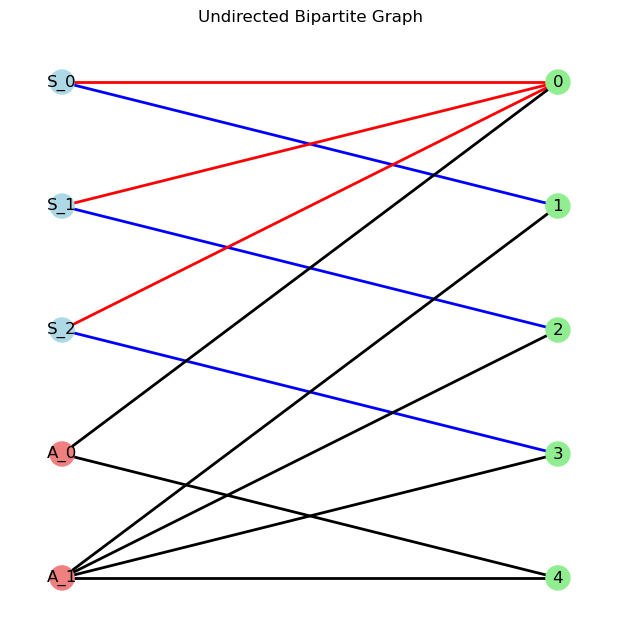

In [24]:
Draw_EPM_bipartite_graph(igraph_to_networkx(result_dict[list(result_dict.keys())[0]][0][2]))

In [26]:
target = ['011', '101', '110']

In [17]:
state_results = check_quantum_states_exist(result_dict, target)

In [22]:
state_results

[('218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8',
  {'011': 1, '101': 1, '110': 1},
  0),
 ('a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a',
  {'011': 1, '101': 1, '110': 1},
  0)]